In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import os
from PIL import Image
import time
from glob import glob
import shutil
from tqdm import tqdm

In [2]:
def create_folder(path_name):
    if not os.path.exists(path_name):
        os.makedirs(path_name)

In [3]:
def remove_contents(path_name):
    for filename in os.listdir(path_name):
        file_path = os.path.join(path_name, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

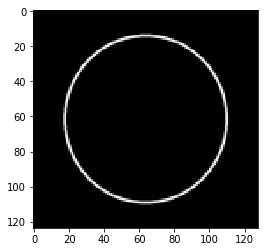

In [4]:
#Read image
img = cv2.imread("circle.png")
plt.imshow(img)

#### Filtro Gabor 

In [5]:
def gabor_filter(K_size,Lambda, Theta, Sigma, Gamma, Psi, mode):

    gabor = np.zeros((K_size, K_size), dtype=np.float32)

    for x in range(K_size):
        for y in range(K_size):
            
            # distancias
            dx = x - K_size // 2
            dy = y - K_size // 2

            x_ = np.cos(Theta) * dx + np.sin(Theta) * dy
            y_ = -np.sin(Theta) * dx + np.cos(Theta) * dy

            gabor[x, y] = np.exp(-(x_**2 + Gamma**2 * y_**2) / (2 * Sigma**2)) * np.cos(2*np.pi*x_/Lambda + Psi)
    
    if mode == 'on':
        gabor = gabor

    elif mode == 'off':
        gabor = -gabor

    return gabor

In [6]:
def apply_filter(gray_img, K_size, Lambda, Theta, Sigma, Gamma, Psi, mode):

    # imagen con los bordes extendidos
    gray = np.pad(gray_img, (K_size//2, K_size//2), 'edge')

    output = np.zeros((gray_img.shape[0],gray_img.shape[1]), dtype=np.float32)

    gabor = gabor_filter(K_size = K_size, Lambda = Lambda, Theta = Theta, Sigma = Sigma, Gamma = Gamma, Psi = 0, mode = mode)
    for x in range(gray_img.shape[0]):
        for y in range(gray_img.shape[1]):
            output[x, y] = np.sum(gray[x : x + K_size, y : y + K_size] * gabor)
            
    return output

In [7]:
def gabor(gray_img,orientation_in_radians, mode):

    output = np.zeros((gray_img.shape[0],gray_img.shape[1]), dtype=np.float32) 
    
    orientation = orientation_in_radians*math.pi/180
    
    output = apply_filter(gray_img, K_size=11, Lambda=3, Theta=orientation, Sigma=1, Gamma=1.2,Psi = 0, mode = mode )
    output = np.clip(output, 0, np.max(output))
    
    return output

## Image

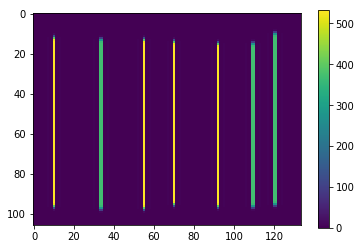

In [8]:
#img = cv2.imread("circle.png")
img = cv2.imread("Captura.PNG")
#img = cv2.imread("sinusoide.png")
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

output = gabor(gray_img,90,'on')

plt.imshow(output)
plt.colorbar()
plt.show()

## Nest

In [9]:
import nest
import pylab
import nest.topology as tp
nest.ResetKernel()
nest.Install('mymodule')

In [10]:
#Set Size
x_cortex_size = 20
y_cortex_size = 20
cortex_size = x_cortex_size * y_cortex_size

In [11]:
def input_treatment(input_spike,x_cortex_size,y_cortex_size,max_value):
    input_as_img = Image.fromarray(input_spike)
    input_resized = input_as_img.resize((x_cortex_size,y_cortex_size))
    input_norm = np.divide(input_resized,np.max(input_resized)) * max_value
    
    input_transposed = input_norm.transpose()
    input_as_list = input_transposed.tolist()
    flat_list = [item for sublist in input_as_list for item in sublist]
    return flat_list

In [12]:
# Orientation = 0 # ON
max_normalized_value = 100.0
output_gabor_0 = gabor(gray_img,0,'on')
input_spike = output_gabor_0[25:45, 25:45]
#input_spike = output_gabor_90[5:55, 5:55]
flat_list_0_on = input_treatment(input_spike,x_cortex_size,y_cortex_size,max_normalized_value)

In [13]:
#flat_list_0_on = [0.0] * x_cortex_size ** 2
#flat_list_0_on[230] = 40.0

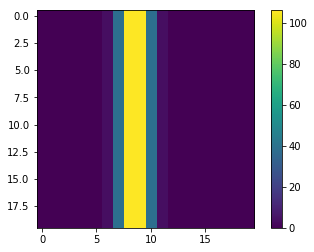

In [14]:
plt.imshow(input_spike)
plt.colorbar()
plt.show()

## Nest Stuff

In [15]:
local_num_threads = 3
total_num_virtual_procs = 2
resolution = 0.1

nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads':local_num_threads})
nest.SetKernelStatus({"total_num_virtual_procs": total_num_virtual_procs})
nest.SetKernelStatus({'print_time':True})
nest.SetKernelStatus({'overwrite_files':True})
nest.SetKernelStatus({"resolution": resolution})

## Models

In [16]:
# Mas adelante meter ruido?
RS_dict =  {'a':0.02, 'b':0.2, 'c':-65.,'d':8.0, 'V_th':30.}
FS_dict =  {'a':0.1, 'b':0.2, 'c':-65., 'd':2.0, 'V_th':30.}

nest.CopyModel("izhikevich","exc", RS_dict)
nest.CopyModel("izhikevich","inh", FS_dict) 

## Layers

In [17]:
def create_layer(rows,columns,extent,elements,neurons_per_column):
    return tp.CreateLayer({'rows': rows,'columns': columns,'extent': extent,'elements': [elements,neurons_per_column],'edge_wrap': False})         

In [18]:
extent = [1.0,1.0]
ratio_exc_inh = 1
neurons_per_column_inh = 1
neurons_per_column_exc = ratio_exc_inh * neurons_per_column_inh
poisson_bias = 5.0

# Orientation 0
l_exc_0_on  = create_layer(x_cortex_size,y_cortex_size,extent,'exc',neurons_per_column_exc)
l_inh_0_on  = create_layer(x_cortex_size,y_cortex_size,extent,'inh',neurons_per_column_inh)
#l_exc_0_off  = create_layer(x_cortex_size,y_cortex_size,extent,'exc')#,neurons_per_column_exc)
#l_inh_0_off  = create_layer(x_cortex_size,y_cortex_size,extent,'inh')#,neurons_per_column_inh)


In [19]:
sum(flat_list_0_on) - poisson_bias*x_cortex_size**2

3619.9312327329317

## Poisson generators

In [20]:
factor = 430

In [21]:
# Poisson layers
l_poiss_0_on = create_layer(x_cortex_size,y_cortex_size,extent,'poisson_generator',1)

fixed_list = [i*factor + poisson_bias for i in flat_list_0_on]
nest.SetStatus(nest.GetNodes(l_poiss_0_on)[0],'rate', fixed_list)


/home/nest/work/install-nest/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:127: UserWarning:
GetNodes is deprecated and will be removed in NEST 3.0. Use             GIDCollection instead.


## Spike Detectors

In [22]:
#Spike detectors
#sd_parrot = nest.Create('spike_detector', params = {'to_file': True})
sd_exc_0_on = nest.Create('spike_detector', params = {'to_file': True})
sd_inh_0_on = nest.Create('spike_detector', params = {'to_file': True})

## Parrot Layers

In [23]:
#l_parrots = create_layer(x_cortex_size,y_cortex_size,extent,'parrot_neuron',1)

## Dictionaries

In [24]:
input_weight_exc = 1.0
input_weight_inh = 1.0
ratio_inh_exc_w = 4
weight_exc = 1.0 
weigth_inh = - ratio_inh_exc_w * weight_exc
delay_exc_min = 2.0
slowness_exc = 5.0
delay_inh_min = 0.5
slowness_inh = 0.01 * slowness_exc
crf_conn_factor = 2.5
stddev_c_rf = 0.08
stddev_lat_conn_inh = 3 * stddev_c_rf
syn_weight_exc = 1
syn_weight_inh = - ratio_inh_exc_w * syn_weight_exc
n_sigmas_inside_mask = 3
n_sigmas_inside_mask_4cbeta = 2.25
stddev_lat_conn_inh_4cbeta = 3 * stddev_c_rf
n_microcolumn_height = 1
n_microcolumn_width = 1
n_rows_rf_4cbeta_cen = int(stddev_c_rf * n_sigmas_inside_mask * 2 * n_microcolumn_height) + 1
n_cols_rf_4cbeta_cen = int(stddev_c_rf * n_sigmas_inside_mask * 2 * n_microcolumn_width) + 1
n_rows_latconn_inh_4cbeta = int(stddev_lat_conn_inh_4cbeta * n_sigmas_inside_mask_4cbeta * 2 * n_microcolumn_height) + 1
n_cols_latconn_inh_4cbeta = int(stddev_lat_conn_inh_4cbeta * n_sigmas_inside_mask_4cbeta * 2 * n_microcolumn_width) + 1
allow_autapses = True
allow_multapses = False

def create_lat_dict(conn_type,weight_type,min_delay_type,slowness_type):
    return  {'connection_type': 'convergent',                   
             'weights': weight_type,
             'delays': {'linear':{'c':min_delay_type,'a':slowness_type}},
             'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses
            }

dict_poiss_to_exc  = {'connection_type': 'divergent','mask': {'grid': {'rows': 1, 'columns': 1}},'weights': input_weight_exc, 
                      'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

dict_poiss_to_inh  = {'connection_type': 'divergent','mask': {'grid': {'rows': 1, 'columns': 1}},'weights': 1.0, 
                      'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

dict_divergent = {'connection_type': 'divergent','mask': {'grid': {'rows': 1, 'columns': 1}},
                      'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

dict_self_exc = {'connection_type': 'convergent', 
                 'mask': {'grid': {'rows': n_rows_rf_4cbeta_cen, 'columns': n_cols_rf_4cbeta_cen},
                          'anchor':{'row':int((n_rows_rf_4cbeta_cen-1)/2),'column':int((n_cols_rf_4cbeta_cen-1)/2)}},
                 'kernel': {'gaussian2D':{'p_center':1., 'sigma_x':stddev_c_rf, 'sigma_y':stddev_c_rf}},
                 'weights': crf_conn_factor * 4 / (neurons_per_column_exc * stddev_c_rf**2), 
                 'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

dict_self_inh = {'connection_type': 'convergent', 
                 'mask': {'grid': {'rows': n_rows_rf_4cbeta_cen, 'columns': n_cols_rf_4cbeta_cen},
                          'anchor':{'row':int((n_rows_rf_4cbeta_cen-1)/2),'column':int((n_cols_rf_4cbeta_cen-1)/2)}},
                 'kernel': {'gaussian2D':{'p_center':1., 'sigma_x':stddev_c_rf, 'sigma_y':stddev_c_rf}},
                 'weights': - crf_conn_factor * 2 * 4 / (neurons_per_column_inh * stddev_c_rf**2), 
                 'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

dict_lat_exc = create_lat_dict('convergent',0.2 * weight_exc,delay_exc_min,slowness_exc)
dict_lat_inh = create_lat_dict('convergent',0.2 * weigth_inh,delay_inh_min,slowness_inh) 
dict_lat_inh_to_exc =  {'connection_type': 'convergent',
                        #'mask': {'grid':{'rows':n_rows_latconn_inh_4cbeta,'columns':n_cols_latconn_inh_4cbeta}, 
                        #         'anchor':{'row':(n_rows_latconn_inh_4cbeta-1)/2,'column':(n_cols_latconn_inh_4cbeta-1)/2}},
                        'delays': {'linear':{'c':delay_inh_min,'a':slowness_inh}},
                        'kernel': {'gaussian2D':{'p_center':1., 'sigma_x':stddev_lat_conn_inh, 'sigma_y':stddev_lat_conn_inh}},
                        'weights': 0.2 * syn_weight_inh , 
                        'allow_autapses': allow_autapses, 'allow_multapses': allow_multapses}

## Connectivity

#### Poisson to layer connections

In [25]:
#tp.ConnectLayers(l_poiss_0_on,l_parrots, dict_divergent)

tp.ConnectLayers(l_poiss_0_on, l_exc_0_on, dict_poiss_to_exc)
tp.ConnectLayers(l_poiss_0_on, l_inh_0_on, dict_poiss_to_inh)

#### Self connections

In [26]:
def update_dict(dictionary, kernel_type, orientation_i, orientation_j):
    new_dict = {'kernel': {kernel_type: {'rows': float(x_cortex_size), 'kappa': 1.0,
                                         'orientation_i': orientation_i, 'orientation_j': orientation_j }}}
    new_dict.update(dictionary)
    return new_dict

In [27]:
tp.ConnectLayers(l_exc_0_on, l_exc_0_on, update_dict(dict_lat_exc,'PlosOne_J',0.0,0.0))
tp.ConnectLayers(l_exc_0_on, l_inh_0_on, update_dict(dict_lat_inh,'PlosOne_W',0.0,0.0))
tp.ConnectLayers(l_inh_0_on, l_exc_0_on, dict_self_inh)
tp.ConnectLayers(l_inh_0_on, l_inh_0_on, dict_self_inh)

#### Lateral conections

#### Record connections

In [28]:
#leaves_parrot = nest.GetLeaves(l_parrots, local_only=True)[0]
#nest.Connect(leaves_parrot, sd_parrot)
#spike_detectors = [sd_parrot]
#layers_to_record = {'l_parrots': l_parrots}
    
leaves_exc_0_on = nest.GetLeaves(l_exc_0_on, local_only=True)[0]
nest.Connect(leaves_exc_0_on, sd_exc_0_on)

leaves_inh_0_on = nest.GetLeaves(l_inh_0_on, local_only=True)[0]
nest.Connect(leaves_inh_0_on, sd_inh_0_on)

spike_detectors = [sd_exc_0_on, sd_inh_0_on]
#spike_detectors = [sd_exc_0_on]
layers_to_record = {'l_exc_0_on': l_exc_0_on, 'l_inh_0_on': l_inh_0_on}
#layers_to_record = {'l_exc_0_on': l_exc_0_on}

/home/nest/work/install-nest/lib/python3.6/site-packages/nest/lib/hl_api_helper.py:127: UserWarning:
GetLeaves is deprecated and will be removed in NEST 3.0. Use             GIDCollection instead.


## Simulation

In [29]:
#Create folder for spike_detectors.gdf
sd_path = 'spk_detectors_folder' 
create_folder(sd_path)
remove_contents(sd_path)

#### Simulate

In [30]:
simulation_time = 1000.0
t = time.time()
nest.Simulate(simulation_time)
print(time.time() - t)

4.25030517578125


In [31]:
#move files
files = glob('*spike_detector*')
for file in files:
    shutil.move(file, sd_path + '/' + file)

## Data treatment

In [32]:
t = time.time()
for layer,j in zip(layers_to_record,range(0,len(layers_to_record))):
    tp.DumpLayerNodes(layers_to_record[layer],'out')
    positions = pd.read_table('out',names = ['Number','x_pos','y_pos'], index_col=False, sep = ' ')
    os.remove('out')
    #positions['Number'] = positions.Number.astype(int)
    
    data = []
    for i in range(0,total_num_virtual_procs): 
        name = sd_path + '/spike_detector-' + str(spike_detectors[j][0]) + '-' + str(i) + '.gdf'
        data.append(pd.read_table(name,names = ['Number','Time'], index_col=False))
    data = pd.concat(data)
    data = data.set_index(([pd.Index([i for i in range(0,len(data))])]))
    data['Number'] = data.Number.astype(float)
    data = pd.merge(data,positions,how = 'left',on = 'Number' )
    #Save dataframe
    data.to_pickle('./data_' + str(layer) +'.pkl')

del(data)
del(positions)
print(time.time() - t)

0.8526990413665771
